In [1]:
import pyspark

In [2]:
from pyspark.sql import SparkSession

In [12]:
# Creating a Spark session
spark = SparkSession.builder.appName("SP500 Companies Analysis").getOrCreate()

In [24]:
columns = 'Exchange string, Symbol string, Shortname string, Longname string, Sector string, Industry string, Currentprice double, Marketcap double, Ebitda double, Revenuegrowth double, City string, State string, Country string, Fulltimeemployees double, Longbusinesssummary string, Weight double'

In [33]:
df = spark.read.csv("sp500_companies.csv", header=True, schema=columns)

In [34]:
df.show(5)

+--------+------+--------------------+--------------------+--------------------+--------------------+------------+-----------------+----------------+-------------+-------------+-----+-------------+-----------------+--------------------+--------------------+
|Exchange|Symbol|           Shortname|            Longname|              Sector|            Industry|Currentprice|        Marketcap|          Ebitda|Revenuegrowth|         City|State|      Country|Fulltimeemployees| Longbusinesssummary|              Weight|
+--------+------+--------------------+--------------------+--------------------+--------------------+------------+-----------------+----------------+-------------+-------------+-----+-------------+-----------------+--------------------+--------------------+
|     NMS|  AAPL|          Apple Inc.|          Apple Inc.|          Technology|Consumer Electronics|      219.86|  3.3713553408E12|1.31781001216E11|        0.049|    Cupertino|   CA|United States|         161000.0|Apple Inc. 

In [35]:
df.printSchema()

root
 |-- Exchange: string (nullable = true)
 |-- Symbol: string (nullable = true)
 |-- Shortname: string (nullable = true)
 |-- Longname: string (nullable = true)
 |-- Sector: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Currentprice: double (nullable = true)
 |-- Marketcap: double (nullable = true)
 |-- Ebitda: double (nullable = true)
 |-- Revenuegrowth: double (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Fulltimeemployees: double (nullable = true)
 |-- Longbusinesssummary: string (nullable = true)
 |-- Weight: double (nullable = true)



In [36]:
df.describe()

DataFrame[summary: string, Exchange: string, Symbol: string, Shortname: string, Longname: string, Sector: string, Industry: string, Currentprice: string, Marketcap: string, Ebitda: string, Revenuegrowth: string, City: string, State: string, Country: string, Fulltimeemployees: string, Longbusinesssummary: string, Weight: string]

In [37]:
df.describe().show()

+-------+--------+--------------------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+
|summary|Exchange|              Symbol|           Shortname|            Longname|              Sector|        Industry|      Currentprice|           Marketcap|              Ebitda|      Revenuegrowth|                City|               State|             Country| Fulltimeemployees| Longbusinesssummary|              Weight|
+-------+--------+--------------------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+
|  count|     504|       

In [38]:
from pyspark.sql.functions import col, isnan, count, when

In [39]:
# Count NULL values in each column
null_counts = df.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in df.columns]
)
null_counts.show()

+--------+------+---------+--------+------+--------+------------+---------+------+-------------+----+-----+-------+-----------------+-------------------+------+
|Exchange|Symbol|Shortname|Longname|Sector|Industry|Currentprice|Marketcap|Ebitda|Revenuegrowth|City|State|Country|Fulltimeemployees|Longbusinesssummary|Weight|
+--------+------+---------+--------+------+--------+------------+---------+------+-------------+----+-----+-------+-----------------+-------------------+------+
|       0|     0|        0|       0|     0|       0|           1|        1|    30|            3|   0|   20|      0|                9|                  0|     5|
+--------+------+---------+--------+------+--------+------------+---------+------+-------------+----+-----+-------+-----------------+-------------------+------+



In [41]:
# Fill missing values for 'Ebitda' with the median value
median_ebitda = df.approxQuantile("Ebitda", [0.5], 0.25)[0]
df = df.fillna({'Ebitda': median_ebitda})

In [47]:
# Fill missing values for 'State' with the mode
mode_state = df.groupBy("State").count().orderBy("count", ascending=False).first()[0]
df = df.fillna({'State': mode_state})

In [48]:
# Fill missing values for 'Fulltimeemployees' with the median value
median_fulltimeemployees = df.approxQuantile("Fulltimeemployees", [0.5], 0.25)[0]
df = df.fillna({'Fulltimeemployees': median_fulltimeemployees})

In [49]:
# Fill missing values for 'Revenuegrowth' with the median value
median_revenuegrowth = df.approxQuantile("Revenuegrowth", [0.5], 0.25)[0]
df = df.fillna({'Revenuegrowth': median_revenuegrowth})

In [52]:
# Fill missing values for 'Weight' with the mode
median_weight = df.approxQuantile("Weight", [0.5], 0.25)[0]
df = df.fillna({'Weight': median_weight})

In [53]:
# Verify no missing values remain
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+------+---------+--------+------+--------+------------+---------+------+-------------+----+-----+-------+-----------------+-------------------+------+
|Exchange|Symbol|Shortname|Longname|Sector|Industry|Currentprice|Marketcap|Ebitda|Revenuegrowth|City|State|Country|Fulltimeemployees|Longbusinesssummary|Weight|
+--------+------+---------+--------+------+--------+------------+---------+------+-------------+----+-----+-------+-----------------+-------------------+------+
|       0|     0|        0|       0|     0|       0|           1|        1|     0|            0|   0|    0|      0|                0|                  0|     0|
+--------+------+---------+--------+------+--------+------------+---------+------+-------------+----+-----+-------+-----------------+-------------------+------+



In [58]:
df = df.dropna()

In [59]:
# Verify no missing values remain
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+------+---------+--------+------+--------+------------+---------+------+-------------+----+-----+-------+-----------------+-------------------+------+
|Exchange|Symbol|Shortname|Longname|Sector|Industry|Currentprice|Marketcap|Ebitda|Revenuegrowth|City|State|Country|Fulltimeemployees|Longbusinesssummary|Weight|
+--------+------+---------+--------+------+--------+------------+---------+------+-------------+----+-----+-------+-----------------+-------------------+------+
|       0|     0|        0|       0|     0|       0|           0|        0|     0|            0|   0|    0|      0|                0|                  0|     0|
+--------+------+---------+--------+------+--------+------------+---------+------+-------------+----+-----+-------+-----------------+-------------------+------+



In [61]:
df.show(5)

+--------+------+--------------------+--------------------+--------------------+--------------------+------------+-----------------+----------------+-------------+-------------+-----+-------------+-----------------+--------------------+--------------------+
|Exchange|Symbol|           Shortname|            Longname|              Sector|            Industry|Currentprice|        Marketcap|          Ebitda|Revenuegrowth|         City|State|      Country|Fulltimeemployees| Longbusinesssummary|              Weight|
+--------+------+--------------------+--------------------+--------------------+--------------------+------------+-----------------+----------------+-------------+-------------+-----+-------------+-----------------+--------------------+--------------------+
|     NMS|  AAPL|          Apple Inc.|          Apple Inc.|          Technology|Consumer Electronics|      219.86|  3.3713553408E12|1.31781001216E11|        0.049|    Cupertino|   CA|United States|         161000.0|Apple Inc. 

In [62]:
# Group by 'Sector' and count the number of companies in each sector
sector_counts = df.groupBy("Sector").agg(count("Symbol").alias("count")).orderBy("count", ascending=False)
sector_counts.show()

+--------------------+-----+
|              Sector|count|
+--------------------+-----+
|          Technology|   78|
|         Industrials|   72|
|  Financial Services|   66|
|          Healthcare|   64|
|   Consumer Cyclical|   57|
|  Consumer Defensive|   37|
|           Utilities|   32|
|         Real Estate|   31|
|Communication Ser...|   22|
|              Energy|   22|
|     Basic Materials|   22|
+--------------------+-----+



In [63]:
# Describe numerical columns to get summary statistics
df.select("Currentprice", "Marketcap", "Ebitda", "Revenuegrowth", "Fulltimeemployees").describe().show()

+-------+------------------+--------------------+--------------------+-------------------+------------------+
|summary|      Currentprice|           Marketcap|              Ebitda|      Revenuegrowth| Fulltimeemployees|
+-------+------------------+--------------------+--------------------+-------------------+------------------+
|  count|               503|                 503|                 503|                503|               503|
|   mean|209.41182902584515|9.906873796555069E10|  6.47823617304175E9|0.05466799204771371| 57356.61232604374|
| stddev|463.47639000424743|2.932765817004652E11|1.448644224189258...|0.19699887533134974|138453.33089867877|
|    min|              8.27|       6.324059648E9|      -4.107000064E9|             -0.573|              28.0|
|    max|           8546.26|     3.3713553408E12|    1.31781001216E11|              2.621|         2100000.0|
+-------+------------------+--------------------+--------------------+-------------------+------------------+



In [64]:
from pyspark.ml.feature import VectorAssembler

C:\Users\jamee\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [78]:
# Select relevant features for the model
feature_columns = ["Marketcap", "Ebitda", "Revenuegrowth", "Fulltimeemployees", "Weight"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [79]:
assembler

VectorAssembler_c00664ddb731

In [80]:
# Transform the data
df_ml = assembler.transform(df)

In [81]:
df_ml.show()

+--------+------+--------------------+--------------------+--------------------+--------------------+------------+-----------------+----------------+-------------+-------------+-----+-------------+-----------------+--------------------+--------------------+--------------------+
|Exchange|Symbol|           Shortname|            Longname|              Sector|            Industry|Currentprice|        Marketcap|          Ebitda|Revenuegrowth|         City|State|      Country|Fulltimeemployees| Longbusinesssummary|              Weight|            features|
+--------+------+--------------------+--------------------+--------------------+--------------------+------------+-----------------+----------------+-------------+-------------+-----+-------------+-----------------+--------------------+--------------------+--------------------+
|     NMS|  AAPL|          Apple Inc.|          Apple Inc.|          Technology|Consumer Electronics|      219.86|  3.3713553408E12|1.31781001216E11|        0.049|

In [89]:
# Select the label and features
df_ml = df_ml.select("features", col("Currentprice").alias("label"))

In [94]:
df_ml.show()

+--------------------+------+
|            features| label|
+--------------------+------+
|[3.3713553408E12,...|219.86|
|[3.036322463744E1...|408.49|
|[2.638659715072E1...|107.27|
|[2.06209155072E12...| 168.4|
|[2.060634292224E1...|166.66|
|[1.761270956032E1...| 167.9|
|[1.234906382336E1...|488.14|
|[9.22798784512E11...|428.36|
|[7.24339851264E11...|804.46|
|[6.69464854528E11...|143.82|
|[6.63430823936E11...|207.67|
|[5.66573203456E11...|199.14|
|[5.50660734976E11...| 68.46|
|[5.42870700032E11...|589.83|
|[5.24315492352E11...|116.88|
|[5.1873267712E11,...|266.58|
|[4.268302336E11,1...|462.02|
|[4.00895574016E11...|170.08|
|[3.95124375552E11...|164.14|
|[3.67301001216E11...|133.28|
+--------------------+------+
only showing top 20 rows



In [96]:
from pyspark.ml.regression import LinearRegression

In [97]:
# Split the data into training and test sets
train_data, test_data = df_ml.randomSplit([0.8, 0.2])

In [98]:
train_data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[6.93997312E9,4.3...|59.35|
|[7.004214272E9,2....|15.93|
|[7.070002688E9,1....|15.71|
|[7.411269632E9,1....| 33.2|
|[7.525487616E9,1....|33.04|
+--------------------+-----+
only showing top 5 rows



In [99]:
test_data.show(5)

+--------------------+------+
|            features| label|
+--------------------+------+
|[6.324059648E9,5....|  9.63|
|[7.803202048E9,2....|  11.0|
|[8.415663104E9,2....| 53.23|
|[8.595315712E9,5....|142.87|
|[8.6070528E9,1.94...|  76.8|
+--------------------+------+
only showing top 5 rows



In [100]:
# Create and train the linear regression model
lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)

In [103]:
# Evaluate the model on test data
test_results = lr_model.evaluate(test_data)
print(f"R^2: {test_results.r2}\nRMSE: {test_results.rootMeanSquaredError}")

R^2: -0.08509694741365692
RMSE: 382.04875804590284


In [104]:
# Print the coefficients and intercept for linear regression
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [7.172823320880719e-09,-4.832226269572768e-09,228.40382784788673,1.5834299120881528e-05,-343027.4443916923]
Intercept: 199.35509797181194


In [106]:
# Make predictions on the test data
predictions = lr_model.transform(test_data)
predictions.select("features", "label", "prediction").show(5)

+--------------------+------+------------------+
|            features| label|        prediction|
+--------------------+------+------------------+
|[6.324059648E9,5....|  9.63|183.04104217844252|
|[7.803202048E9,2....|  11.0| 202.0855976007848|
|[8.415663104E9,2....| 53.23|236.62034466622447|
|[8.595315712E9,5....|142.87|198.63234899410816|
|[8.6070528E9,1.94...|  76.8| 263.4562043317798|
+--------------------+------+------------------+
only showing top 5 rows



In [107]:
import pandas as pd
import matplotlib.pyplot as plt

In [108]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
predictions_pd = predictions.toPandas()

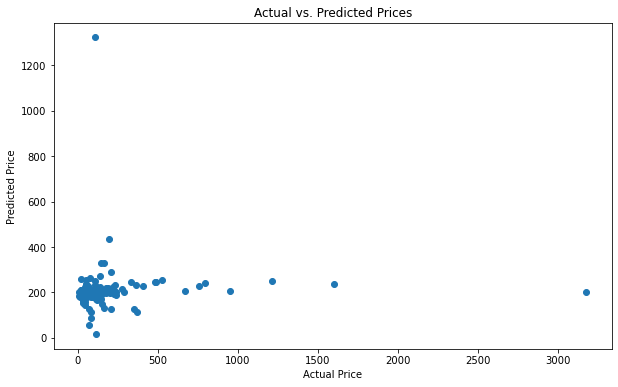

In [109]:
# Scatter plot of actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['label'], predictions_pd['prediction'])
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Prices')
plt.show()